https://medium.com/@srijith.rajamohan/using-bayesian-hierarchical-models-in-pymc3-to-infer-the-disease-parameters-of-covid-19-b396c8b9845
https://databricks.com/blog/2021/01/06/bayesian-modeling-of-the-temporal-dynamics-of-covid-19-using-pymc3.html
https://sjster.github.io/introduction_to_computational_statistics/docs/Production/Covid_modeling.html


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff
import scipy.stats
import pymc3 as pm
import arviz as az
import sunode
import sunode.wrappers.as_theano
from pymc3.ode import DifferentialEquation
import theano.tensor as tt
import theano
import datetime
import shelve
from datetime import datetime as dt
import time

In [2]:
class COVID_data():
     
    def __init__(self, country='US', Population = 328.2e6):
 
        confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
        self.confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
        deaths_url =  'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
        self.deaths = pd.read_csv(deaths_url, sep=',')
        path_to_save = ''
 
        # ------------------------- Country for inference -------------------
 
        self.country = country
        self.N = Population   # Population of the country
                         # Germany - 83.7e6
                         # US - 328.2e6
 
    def get_dates(self, data_begin='7/11/20', data_end='7/20/20'):
 
        # ------------------------- Date for inference ----------------------#
        self.data_begin = data_begin  #Take the data until yesterday
        self.data_end = data_end
        self.num_days_to_predict = 14
        confirmed_cases = self.confirmed_cases
        country = self.country
        self.cases_country = confirmed_cases.loc[confirmed_cases["Country/Region"] == country]
        self.cases_obs = np.array(confirmed_cases.loc[confirmed_cases["Country/Region"] == country, data_begin:data_end])[0]
 
        print("------------ Cases for selected period ----------- ",self.cases_obs)
 
        date_data_end = confirmed_cases.loc[confirmed_cases["Country/Region"] == self.country, data_begin:data_end].columns[-1]
        month, day, year = map(int,date_data_end.split('/'))
        date_data_end = datetime.date(year+2000, month, day)
        date_today = date_data_end + datetime.timedelta(days=1)
        print("------------- Cases yesterday ({}): {} and day before yesterday: {} ------------".format(date_data_end.isoformat(), *self.cases_obs[:-3:-1]))
        self.num_days = len(self.cases_obs)
 
        day_before_start = dt.strptime(data_end, '%m/%d/%y') + datetime.timedelta(days=-1)
        day_before_start_cases = np.array(self.cases_country.loc[:, day_before_start.strftime('%-m/%-d/%-y')])
        print("------------ Day before start and cases for that date ------------", day_before_start, day_before_start_cases)
        future_days_begin = dt.strptime(data_end, '%m/%d/%y') + datetime.timedelta(days=1)
        future_days_end = future_days_begin + datetime.timedelta(days=self.num_days_to_predict)
        self.future_days_begin_s = future_days_begin.strftime('%-m/%-d/%-y')
        self.future_days_end_s = future_days_end.strftime('%-m/%-d/%-y')
        print("------------- Future date begin and end -------------",self.future_days_begin_s, self.future_days_end_s)
        self.future_days = np.array(self.cases_country.loc[:, self.future_days_begin_s : self.future_days_end_s])[0]
        print("------------- Future days cases ------------", self.future_days)

In [3]:
class SIR_model():
     
    def __init__(self, covid_data) :
 
        # ------------------------- Covid_data object -----------------------#
        self.covid_data = covid_data
        # ------------------------- Setup SIR model, but has to be called explicitly to run ------------------------#
        self.setup_SIR_model()
 
    def SIR_non_normalized(self, y, t, p):
        ds = -p[0] * y[0] * y[1] /self.covid_data.N
        di = p[0] * y[0] * y[1] / self.covid_data.N  -  p[1] * y[1]
        return [ds, di]
 
    def setup_SIR_model(self):
        self.time_range = np.arange(0,len(self.covid_data.cases_obs),1)
        self.I0 = self.covid_data.cases_obs[0]
        self.S0 = self.covid_data.N - self.I0
 
        # SIR model
        self.sir_model_non_normalized = DifferentialEquation(
            func=self.SIR_non_normalized,
            times=self.time_range[1:],
            n_states=2,
            n_theta=2,
            t0=0)
 
    def run_SIR_model(self, n_samples, n_tune, likelihood, prior):
        # ------------------------- Metadata --------------------------------#
        now = dt.now()
        timenow = now.strftime("%d-%m-%Y_%H:%M:%S")
        self.filename = 'sir_' + self.covid_data.data_begin.replace('/','-') + '_' + \
            self.covid_data.data_end.replace('/','-') + '_' + timenow
        self.likelihood = likelihood
        self.n_samples = n_samples
        self.n_tune = n_tune
        self.likelihood = likelihood
        self.prior = prior
        # ------------------------ Write out metadata while the model is running -------------------#
        metadata_db_filename = 'metadata_db.db'
 
        t = time.time()
 
        with pm.Model() as model4:
            sigma = pm.HalfCauchy('sigma', likelihood['sigma'], shape=1)
            lam = pm.Lognormal('lambda', prior['lam'], prior['lambda_std'])
            mu = pm.Lognormal('mu', prior['mu'], prior['mu_std'])
 
            res = self.sir_model_non_normalized(y0=[self.S0, self.I0], theta=[lam, mu])
 
            if(likelihood['distribution'] == 'lognormal'):
                Y = pm.Lognormal('Y', mu=pm.math.log(res.take(0, axis=1)), sigma=sigma, observed=self.covid_data.cases_obs[1:])
            else:
                Y = pm.StudentT( "Y",  nu=likelihood['nu'],       # likelihood distribution of the data
                        mu=res.take(0, axis=1),     # likelihood distribution mean, these are the predictions from SIR
                        sigma=sigma,
                        observed=cases_obs[1:]
                        )
            trace = pm.sample(self.n_samples, tune=self.n_tune, target_accept=0.9, 
                              ######
                              cores=1)#2
                              ######  
            data = az.from_pymc3(trace=trace)
 
        t1 = time.time() - t
        az.plot_posterior(data, round_to=2, credible_interval=0.95)
        axes = az.plot_trace(trace)
        fig = axes.ravel()[0].figure
        fig.savefig(self.filename)
 
        self.metadata_db = shelve.open(metadata_db_filename)
        self.metadata_db[self.filename] = {'type': 'sir', 'samples': n_samples,
                                    'tune': n_tune,
                                    'elapsed_time': t1,
                                    'finished': dt.now().strftime("%d-%m-%Y_%H:%M:%S"),
                                    'likelihood': likelihood,
                                    'prior': prior }
        self.metadata_db.close()
 
 

In [4]:
class SIR_model_sunode():
 
    def __init__(self, covid_data) :
 
        # ------------------------- Covid_data object -----------------------#
        self.covid_data = covid_data
        # ------------------------- Setup SIR model, but has to be called explicitly to run ------------------------#
        self.setup_SIR_model()
 
    def SIR_sunode(self, t, y, p):
        return {
            'S': -p.lam * y.S * y.I,
            'I': p.lam * y.S * y.I - p.mu * y.I,
        }
 
    def setup_SIR_model(self):
        self.time_range = np.arange(0,len(self.covid_data.cases_obs),1)
        self.I0 = self.covid_data.cases_obs[0]
        self.S0 = self.covid_data.N - self.I0
        self.S_init = self.S0 / self.covid_data.N
        self.I_init = self.I0 / self.covid_data.N
        self.cases_obs_scaled = self.covid_data.cases_obs / self.covid_data.N
 
 
    def run_SIR_model(self, n_samples, n_tune, likelihood, prior):
        # ------------------------- Metadata --------------------------------#
        now = dt.now()
        timenow = now.strftime("%d-%m-%Y_%H:%M:%S")
        self.filename = 'sir_' + self.covid_data.data_begin.replace('/','-') + '_' + \
            self.covid_data.data_end.replace('/','-') + '_' + timenow
        self.likelihood = likelihood
        self.n_samples = n_samples
        self.n_tune = n_tune
        self.likelihood = likelihood
        self.prior = prior
        # ------------------------ Write out metadata while the model is running -------------------#
        metadata_db_filename = 'metadata_db.db'
 
        t = time.time()
 
        with pm.Model() as model4:
            sigma = pm.HalfCauchy('sigma', self.likelihood['sigma'], shape=1)
            lam = pm.Lognormal('lambda', self.prior['lam'], self.prior['lambda_std']) # 1.5, 1.5
            mu = pm.Lognormal('mu', self.prior['mu'], self.prior['mu_std'])           # 1.5, 1.5
            res, _, problem, solver, _, _ = sunode.wrappers.as_theano.solve_ivp(
            y0={
                'S': (self.S_init, ()), 'I': (self.I_init, ()),},
            params={
                'lam': (lam, ()), 'mu': (mu, ()), '_dummy': (np.array(1.), ())},
            rhs=self.SIR_sunode,
            tvals=self.time_range,
            t0=self.time_range[0]
            )
            if(likelihood['distribution'] == 'lognormal'):
                I = pm.Lognormal('I', mu=res['I'], sigma=sigma, observed=self.cases_obs_scaled)
            elif(likelihood['distribution'] == 'normal'):
                I = pm.Normal('I', mu=res['I'], sigma=sigma, observed=self.cases_obs_scaled)
            elif(likelihood['distribution'] == 'students-t'):
                I = pm.StudentT( "I",  nu=likelihood['nu'],       # likelihood distribution of the data
                        mu=res['I'],     # likelihood distribution mean, these are the predictions from SIR
                        sigma=sigma,
                        observed=self.cases_obs_scaled
                        )
            R0 = pm.Deterministic('R0',lam/mu)
            
            trace = pm.sample(self.n_samples, tune=self.n_tune, chains=4, 
                              ######
                              cores=1)#4
                              ######          
            data = az.from_pymc3(trace=trace)
 
        t1 = time.time() - t
        az.plot_posterior(data, round_to=2, point_estimate='mode', hdi_prob=0.95)
        axes = az.plot_trace(trace)
        fig = axes.ravel()[0].figure
        fig.savefig(self.filename)
        
        fig = ff.create_distplot([trace['R0']], bin_size=0.5, group_labels=['x'])
 
        # Add title
        fig.update_layout(title_text='Curve and Rug Plot')
        fig.update_xaxes(range=[0,7])
              
 
        self.metadata_db = shelve.open(metadata_db_filename)
        self.metadata_db[self.filename] = {'type': 'sir', 'samples': n_samples,
                                    'tune': n_tune,
                                    'elapsed_time': t1,
                                    'finished': dt.now().strftime("%d-%m-%Y_%H:%M:%S"),
                                    'likelihood': likelihood,
                                    'prior': prior }
        self.metadata_db.close()
        return(fig)
 
 
 

------------ Cases for selected period -----------  [      8       8      11      11      11      12      12      12      12
      12      13      13      14      14      14      14      14      14
      14      14      16      16      16      16      16      16      17
      17      25      32      55      74     107     184     237     403
     519     594     782    1147    1586    2219    2978    3212    4679
    6512    9169   13663   20030   26025   34944   46096   56714   68841
   86662  105253  127417  143544  165698  192079  224311  256541  289023
  321199  350803  382661  413004  444153  480596  514943  544221  571093
  598017  626412  652312  682268  715425  743419  769342  799022  825192
  854611  887380  919532  950526  977073 1000823 1025513 1051733 1080974
 1115995 1143819 1168311 1192024 1216353 1240616 1268273 1295545 1319991
 1339139 1358173 1381016 1401592 1428124 1452945 1477178 1495976 1518110
 1538870 1561592 1587398 1611017 1631996 1652587 1671240 1689816 1709222

/var/folders/jd/44pp_2p960lgrfy2wcw2g7440000gp/T/ipykernel_8385/1941963143.py:66: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(self.n_samples, tune=self.n_tune, chains=4,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu, lambda, sigma]



[CVODES ERROR]  CVode
  At t = 0.0161864, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00588324, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0139545, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0124825, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00893006, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00693832, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODE


[CVODES ERROR]  CVode
  At t = 0.0498539, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00162809, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.187291, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.122326, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.171627, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.206269, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.00307942, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00990894, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0281371, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0630427, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0528528, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0218169, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES


[CVODES ERROR]  CVode
  At t = 0.00541247, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0404385, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0123436, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00618462, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00888433, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00801476, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVOD

NameError: name 'ff' is not defined

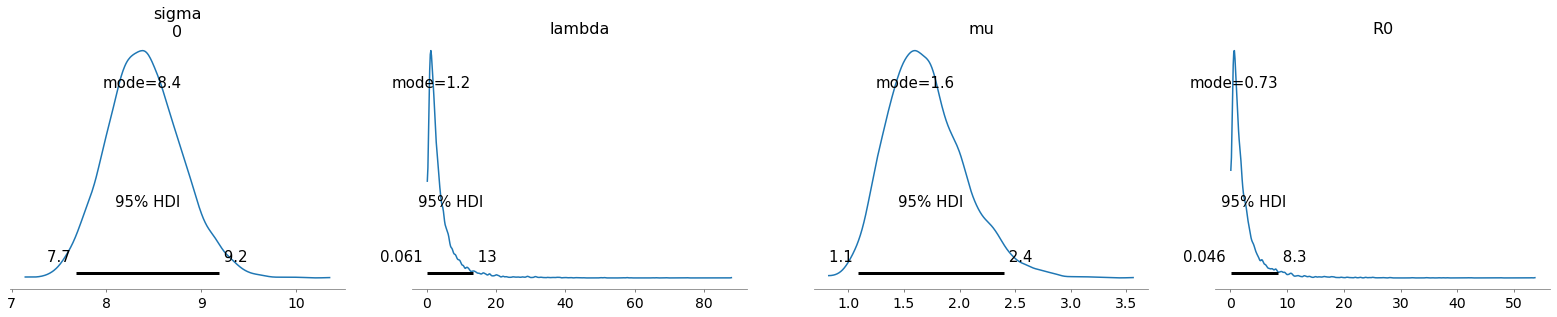

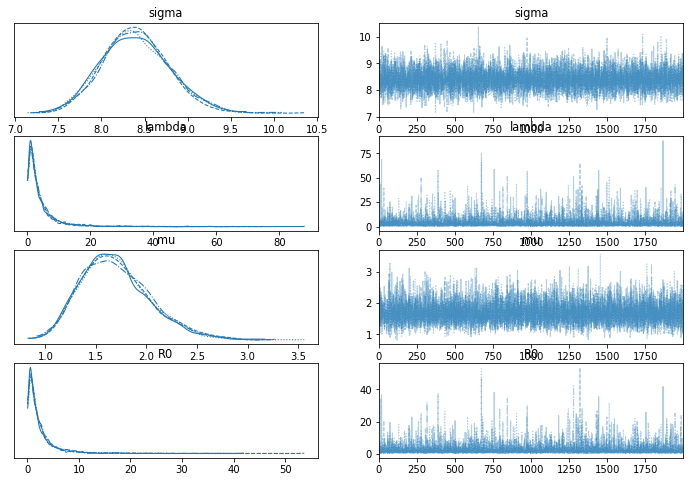

In [9]:
# -------- Usage --------#
covid_obj = COVID_data('US', Population=328.2e6)
covid_obj.get_dates(data_begin='2/1/20', data_end='9/28/20')
sir_model = SIR_model_sunode(covid_obj)
likelihood = {'distribution': 'lognormal', 
              'sigma': 2}
prior = {'lam': 1.0, 
         'mu': 0.5, 
         'lambda_std': 1.0,
         'mu_std': 0.2 }
fig1 = sir_model.run_SIR_model(n_samples=2000, n_tune=1000, likelihood=likelihood, prior=prior)

In [9]:
pm.__version__

'3.11.2'